In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# matplotlib config
plt.rcParams['axes.grid'] = True

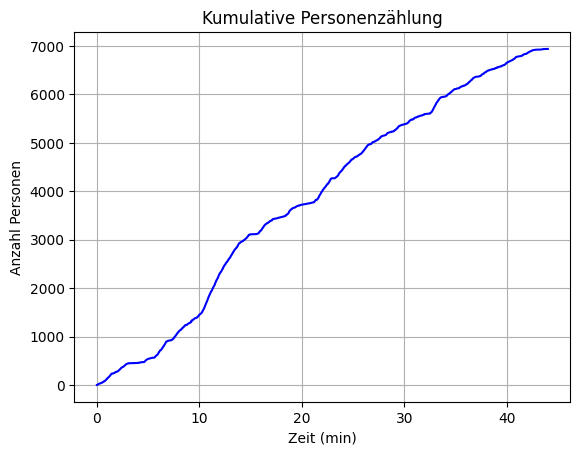

In [17]:
# read marking csv
markings_path = "data/markings-bremen.csv"

# ...[1:] to ignore header row
csv_data = np.genfromtxt(markings_path, delimiter=',')[1:]

# sort markings by timestamp
csv_data = csv_data[csv_data[:, 0].argsort()]

# marking timestamp [ms] -> [s]
marking_times = csv_data[:, 0] / 1000
marking_times -= marking_times[0]
cumulative_marking_count = np.array(range(1, len(marking_times) + 1))

# marking positions [0, 100] -> [0, 1]
marking_positions = csv_data[:, 1:] / 100

plt.title("Kumulative Personenzählung")
plt.xlabel("Zeit (min)")
plt.ylabel("Anzahl Personen")
plt.plot(marking_times / 60, cumulative_marking_count, "-b")

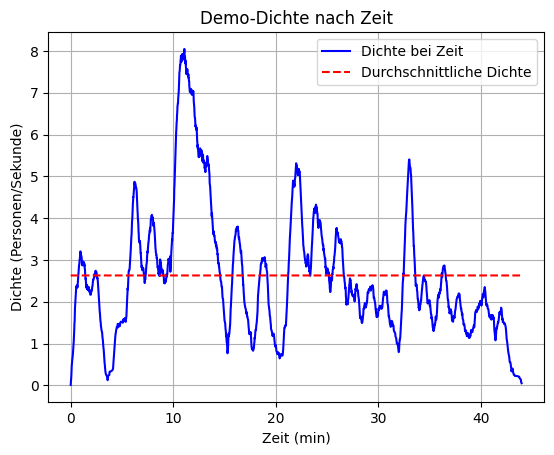

In [18]:
def linearly_interpolate(x, y, x_value):
    if x_value <= x[0]:
        return x[0]
    elif x_value >= x[-1]:
        return x[-1]
    
    for curr_x, next_x, curr_y, next_y in zip(x, x[1:], y, y[1:]):
        if curr_x <= x_value and x_value <= next_x:
            if curr_x == next_x:
                return curr_x
            progress = (x_value - curr_x) / (next_x - curr_x)
            return (1 - progress) * curr_y + progress * next_y
        
    assert 1 == 2, "Didn't expect to get here"

def uniform_resample(x, y, sample_interval):
    curr_t = x[0]
    resample = []
    new_x = []
    while curr_t < x[-1]:
        value_at_t = linearly_interpolate(x, y, curr_t)
        resample.append(value_at_t)
        new_x.append(curr_t)
        curr_t += sample_interval
    return np.array(new_x), np.array(resample)

def gradient(x, y):
    values = np.zeros(len(x) - 1)
    for i, (x, x_prev, y, y_prev) in enumerate(zip(x[1:], x, y[1:], y)):
        dx = x - x_prev
        dy = y - y_prev
        values[i] = dy / dx
    return values

uniform_x, uniform_count = uniform_resample(marking_times, cumulative_marking_count, 1)
smooth_count = uniform_filter1d(uniform_count, size=60)

gradient_times = uniform_x[:-1] / 60
average_density = len(marking_times) / marking_times[-1]

plt.title("Demo-Dichte nach Zeit")
plt.xlabel("Zeit (min)")
plt.ylabel("Dichte (Personen/Sekunde)")
plt.plot(gradient_times, gradient(uniform_x, smooth_count), "-b", label="Dichte bei Zeit")
plt.plot(gradient_times, [average_density] * len(gradient_times), "--r", label="Durchschnittliche Dichte")
plt.legend()

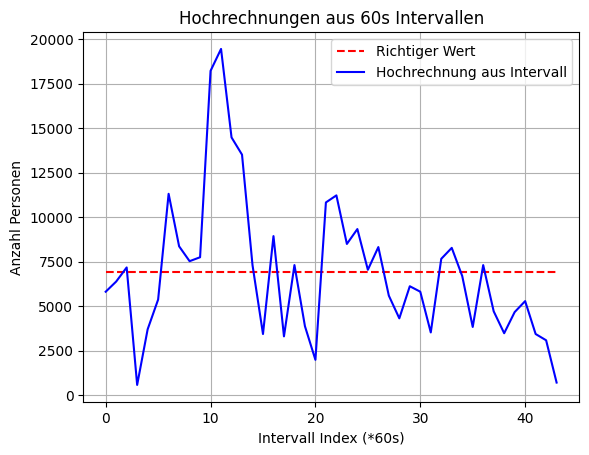

In [19]:
interval_length_seconds = 60
people_per_interval = []
next_interval_start_timestamp = None

for timestamp in marking_times:
    if next_interval_start_timestamp is None or next_interval_start_timestamp <= timestamp:
        people_per_interval.append(1)
        if next_interval_start_timestamp is None:
            next_interval_start_timestamp = interval_length_seconds
        else:
            next_interval_start_timestamp += interval_length_seconds
    else:
        people_per_interval[-1] += 1

predictions = np.array(people_per_interval) / interval_length_seconds * marking_times[-1]
plt.title(f"Hochrechnungen aus {interval_length_seconds}s Intervallen")
plt.xlabel(f"Intervall Index (*{interval_length_seconds}s)")
plt.ylabel("Anzahl Personen")
plt.plot([len(marking_times)] * len(predictions), "--r", label="Richtiger Wert")
plt.plot(predictions, "-b", label="Hochrechnung aus Intervall")
plt.legend()

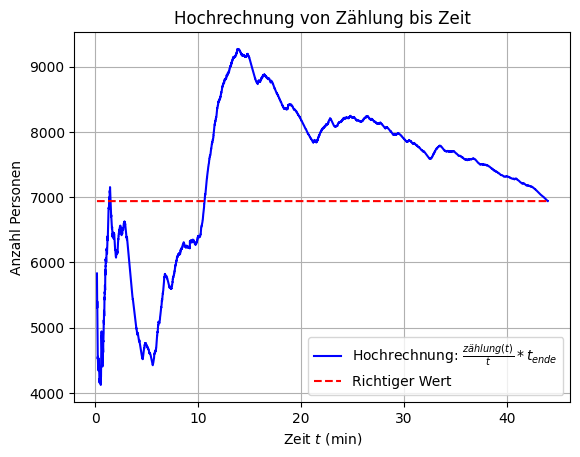

In [22]:
predictions = []
minute_timestamps = []
total_seconds = marking_times[-1]
skip_seconds = 10

for i, timestamp in enumerate(marking_times):
    if timestamp < skip_seconds:
        continue
    count_so_far = i + 1
    prediction = count_so_far / timestamp * total_seconds
    predictions.append(prediction)
    minute_timestamps.append(timestamp / 60)

plt.title("Hochrechnung von Zählung bis Zeit")
plt.xlabel("Zeit $t$ (min)")
plt.ylabel("Anzahl Personen")
plt.plot(minute_timestamps, predictions, "-b", label=r"Hochrechnung: $\frac{zählung(t)}{t} * t_{ende}$")
plt.plot(minute_timestamps, [predictions[-1]] * len(minute_timestamps), "--r", label="Richtiger Wert")
plt.legend(loc="lower right")